In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import os
import time
import copy
import pickle
import random
from random import shuffle 
import matplotlib.pyplot as plt
from scipy import spatial

from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
# from keras.utils.np_utils import to_categorical
from gensim.models import Word2Vec
from multiprocessing import cpu_count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
# from torchtext.data import Example
# import torchtext

torch.manual_seed(10)


%load_ext autoreload
%autoreload 2
this = sys.modules[__name__]

In [0]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
# from model import lstm
# os.chdir(curDir+'/data')
import reader # reader.py

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


In [0]:
def read_preTrained(file_name):
    with open(file_name,'r') as f:
        word_vocab = set() # not using list to avoid duplicate entry
        word2vector = {}
        for line in f:
            line_ = line.strip() #Remove white space
            words_Vec = line_.split()
            if len(words_Vec) > 301:
                continue
            try:
                word_vocab.add(words_Vec[0])
                word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
            except ValueError:
                continue
    return word_vocab,word2vector

def read_numpy_files():
    """Instead of running the entire pipeline at all times."""
    filename = os.path.join(curDir, 'data', 'train_test_data.dat') ##@
    with open(filename, 'rb') as handle:
        x_train = pickle.load(handle)
        y_train = pickle.load(handle)
        x_test = pickle.load(handle)
        y_test = pickle.load(handle)
        int_category = pickle.load(handle)
        category_int = pickle.load(handle)

    return (x_train, y_train), (x_test, y_test), int_category, category_int

def seed_everything(seed=10):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [0]:
document_max_num_words = 15
emb_dim = 300
firstTime = False
cache = True
reuters = False
reader.generate_categories(reuters)
class_names = reader.categories 
print('reading data...')
print('# of dimensions is: ', emb_dim)
(x_train, y_train), (x_test, y_test), int_category, category_int = read_numpy_files()
# vocabulary = np.insert(np.load('./data/vocabulary.npy'), 0, '')
vocabulary = np.load('./data/vocabulary.npy')
categories = np.load('./data/categories.npy')
print('Training data size: ', x_train.shape, y_train.shape)
print('Testing data size: ', x_test.shape, y_test.shape)
print('Vocabulary size: ', len(vocabulary))
print('Categories: ', len(categories), categories)
# print(int_category)
# word_to_ix = {word: i for i, word in enumerate(vocabulary)}
# bad_score = ['COLLEGE', 'ENVIRONMENT', 'FIFTY', 'HEALTHY LIVING', 'LATINO VOICES', 'MONEY', 'PARENTS', 'TASTE', 'WORLD NEWS']
# x_train = reader.vectorize_idx(x_train, word_to_ix, document_max_num_words)
# y_train = np.array(list(y_train.values()))
# x_test = reader.vectorize_idx(x_test, word_to_ix, document_max_num_words)
# y_test = np.array(list(y_test.values()))
# reader.save_data(x_train, y_train, x_test, y_test, int_category, category_int)

reading data...
# of dimensions is:  300
Training data size:  (160682, 15) (160682, 40)
Testing data size:  (40171, 15) (40171, 40)
Vocabulary size:  55618
Categories:  40 ['ARTS' 'ARTS & CULTURE' 'BLACK VOICES' 'BUSINESS' 'COLLEGE' 'COMEDY'
 'CRIME' 'CULTURE & ARTS' 'DIVORCE' 'EDUCATION' 'ENTERTAINMENT'
 'ENVIRONMENT' 'FIFTY' 'FOOD & DRINK' 'GOOD NEWS' 'GREEN' 'HEALTHY LIVING'
 'HOME & LIVING' 'IMPACT' 'LATINO VOICES' 'MEDIA' 'MONEY' 'PARENTING'
 'PARENTS' 'POLITICS' 'QUEER VOICES' 'RELIGION' 'SCIENCE' 'SPORTS' 'STYLE'
 'STYLE & BEAUTY' 'TASTE' 'TECH' 'TRAVEL' 'WEDDINGS' 'WEIRD NEWS'
 'WELLNESS' 'WOMEN' 'WORLD NEWS' 'WORLDPOST']


In [0]:
y = np.concatenate((y_train, y_test))
unique, counts = np.unique(y, return_counts=True,axis=0)
print(dict(zip(unique.argmax(1), counts)))
states = counts[::-1]/len(y)
# pos_weight=np.copy(states)
# pos_weight[np.where(pos_weight<0.01)]=5
# pos_weight[np.where(pos_weight<0.02)]=2
# pos_weight[np.where(pos_weight<0.05)]=1
# pos_weight[np.where(pos_weight<0.16)]=0.5
# pos_weight[np.where(states>=0.16)]=0.25
pos_weight=states.min()/states*5
print(pos_weight)

{39: 6243, 38: 2177, 37: 3490, 36: 17827, 35: 2670, 34: 3651, 33: 9887, 32: 2082, 31: 2096, 30: 9649, 29: 2254, 28: 4884, 27: 2178, 26: 2556, 25: 6314, 24: 32739, 23: 3955, 22: 8677, 21: 1707, 20: 2815, 19: 1129, 18: 3459, 17: 4195, 16: 6694, 15: 2622, 14: 1398, 13: 6226, 12: 1401, 11: 1323, 10: 16058, 9: 1004, 8: 3426, 7: 1030, 6: 3405, 5: 5175, 4: 1144, 3: 5937, 2: 4528, 1: 1339, 0: 1509}
[3.32670643 3.74906647 1.10865724 0.84554489 4.38811189 0.97004831
 1.4743025  4.87378641 1.46526562 5.         0.31261676 3.79440665
 3.58315489 0.80629618 3.59084406 1.91456903 0.74992531 1.19666269
 1.4512865  4.44641275 1.78330373 2.94083187 0.57854097 1.26927939
 0.15333394 0.7950586  1.96400626 2.30486685 1.02784603 2.22715173
 0.52026117 2.39503817 2.41114313 0.50773743 1.37496576 1.88014981
 0.28159533 1.43839542 2.30592559 0.80410059]


In [0]:
# vocab, w2v = read_preTrained("./model/glove_files/glove.840B.300d.txt")
# print("Total Words in DataSet:",len(vocab))
# emb_dim = w2v[list(vocab)[0]].shape[0]
# matrix_len = len(vocabulary)
# weights_matrix = np.zeros((matrix_len, emb_dim))
# words_not_found = 0
# n_words = []

# for i, word in enumerate(vocabulary):
#     try: 
#         weights_matrix[i] = w2v[word]
#     except KeyError:
#         weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))
#         words_not_found += 1
#         n_words.append(word)

# print('words not found:', words_not_found)
# print('random embedded words percentage = %.2f%%'%(words_not_found/(matrix_len)*100))
# import gc
# w2v.clear() 
# del w2v, vocab
# gc.collect()
# len(n_words)
# n_words[:50]
# np.savez_compressed('./data/weights_matrix_840B', weights_matrix)
weights_matrix = np.load('./data/weights_matrix_840B.npz')['arr_0']
weights_matrix = torch.tensor(weights_matrix, dtype=torch.float64)
print(weights_matrix.size())

torch.Size([55618, 300])


In [0]:
class MyDataset(Dataset):
    def __init__(self,dataset):
        self.dataset = dataset
    def __getitem__(self,index):
        data,target = self.dataset[index]
        return data,target,index
    def __len__(self):
        return len(self.dataset)

In [0]:
class LSTMTopic(nn.Module):

    def __init__(self, weights_matrix, lstm_out, dense_out, num_categories, noEmbTrain=True, uselast=True, maxpool=False):
        super(LSTMTopic, self).__init__()
        self.hidden_dim = lstm_out[1]
        self.uselast = uselast
        self.maxpool = maxpool
        num_embeddings, embedding_dim = weights_matrix.size()
        self.embedding = nn.Embedding.from_pretrained(weights_matrix, freeze=noEmbTrain)
        #self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm1 = nn.LSTM(embedding_dim, self.hidden_dim , 2, batch_first=True, dropout=0.5)
        self.lstm2 = nn.LSTM(embedding_dim, self.hidden_dim , 1, batch_first=True)
        # The linear layer that maps from hidden state space to tag space
        # self.dense= nn.Linear(self.hidden_dim , dense_out)
        # self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.5)
        self.out = nn.Linear(self.hidden_dim , num_categories)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, inputs):
        x = self.embedding(inputs)
        x, (h, c) = self.lstm1(x.float())
        #x, _ = nn.utils.rnn.pad_packed_sequence(x)
        x = self.drop(x)
        # x, _ = self.lstm2(x)
        # x, _ = self.lstm3(x)
        if self.uselast:
            x = x[:,-1].view(len(x), -1)
        elif self.maxpool:
            x = torch.transpose(x, 1, 2)#torch.Size([batch, hidden, seq])
            x = torch.tanh(x)
            x, indices = F.max_pool1d(x,x.size(2), return_indices=True)
            x = torch.tanh(x)
            x = x.squeeze(2)
        else:
            x = torch.mean(x, dim=1)
        # x = self.relu(self.dense(x))
        # x = self.drop(x)
        x = self.out(x)
        x = self.softmax(x)
        return x

In [0]:
num_categories = len(categories)
batch_size=128 
n_lr = 5e-3
decay = 1e-7
n_epochs = 20
lstm_out = [128,64,32]
dense_layer = 64
SEED = 10
n_splits = 9

In [0]:
def pytorch_model_run_cv(x_train,y_train,features,x_test, y_test, model_obj, Cats, pos_weight, feats = False,clip = True):
    seed_everything()
    avg_losses_f = []
    avg_val_losses_f = []
    avg_accs_f = []
    avg_val_accs_f = []
    pos_weight = torch.tensor(pos_weight, dtype=torch.float32).cuda()
    # matrix for the out-of-fold predictions
    train_preds = np.zeros((len(x_train),Cats))
    # matrix for the predictions on the test set
    test_preds = np.zeros((len(x_test), Cats))
    splits = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED).split(x_train, y_train[:,1])
    x_test = torch.tensor(x_test, dtype=torch.long).cuda()
    y_test = torch.tensor(y_test, dtype=torch.float32).cuda()
    test = MyDataset(torch.utils.data.TensorDataset(x_test, y_test))
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
    for i, (train_idx, valid_idx) in enumerate(splits):
        seed_everything(i*1000+i)
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        if feats:
            features = np.array(features)
        x_train_fold = torch.tensor(x_train[train_idx.astype(int)], dtype=torch.long).cuda()
        y_train_fold = torch.tensor(y_train[train_idx.astype(int), np.newaxis], dtype=torch.float32).cuda()
        if feats:
            kfold_X_features = features[train_idx.astype(int)]
            kfold_X_valid_features = features[valid_idx.astype(int)]
        x_val_fold = torch.tensor(x_train[valid_idx.astype(int)], dtype=torch.long).cuda()
        y_val_fold = torch.tensor(y_train[valid_idx.astype(int), np.newaxis], dtype=torch.float32).cuda()

        model = copy.deepcopy(model_obj)

        model.cuda()

        loss_fn = nn.BCELoss()#(pos_weight=pos_weight)#(reduction='sum')

        step_size = 300
        base_lr, max_lr = n_lr/5, n_lr   
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                                 lr=max_lr)

        ################################################################################################
        scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr,
                   step_size_up=step_size, mode='exp_range',
                   gamma=0.99994, cycle_momentum=False)
        ###############################################################################################
        #print('xtrain',X_train[0])
        #print('xtrainF',x_train_fold[0])

        train = MyDataset(torch.utils.data.TensorDataset(x_train_fold, y_train_fold))
        #print('train',train[0])
        valid = MyDataset(torch.utils.data.TensorDataset(x_val_fold, y_val_fold))

        train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
        #print('loader',train_loader[0])
        valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

        print(f'Fold {i + 1}')
        for epoch in range(n_epochs):
            start_time = time.time()
            model.train()

            avg_loss = 0.  
            avg_acc = 0.
            for i, (x_batch, y_batch, index) in enumerate(train_loader):
                y_batch = y_batch.view(len(y_batch), -1)
                if feats:       
                    f = kfold_X_features[index]
                    y_pred = model([x_batch,f])
                else:
                    y_pred = model(x_batch)

                
                # Compute and print loss.
                #print(y_pred.shape, y_batch.shape)
                loss = loss_fn(y_pred, y_batch)
                optimizer.zero_grad()
                loss.backward()
                if clip:
                    nn.utils.clip_grad_norm_(model.parameters(),1)
                optimizer.step()
                if scheduler:
                    scheduler.step()

                avg_loss += loss.item() / len(train_loader)
                acc =(y_pred.argmax(dim=1)==y_batch.argmax(dim=1)).sum().cpu().numpy()/len(y_pred)
                avg_acc += acc / len(train_loader)
            #avg_loss /= i+1
            #avg_acc /= i+1
                

            model.eval()

            valid_preds_fold = np.zeros((x_val_fold.size(0), Cats))
            test_preds_fold = np.zeros((len(x_test), Cats))

            avg_val_loss = 0.
            avg_val_acc = 0.
            for i, (x_batch, y_batch, index) in enumerate(valid_loader):
                y_batch = y_batch.view(len(y_batch), -1)
                if feats:
                    f = kfold_X_valid_features[index]            
                    y_pred = model([x_batch,f]).detach()
                else:
                    y_pred = model(x_batch).detach()

                avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
                val_acc =(y_pred.argmax(dim=1)==y_batch.argmax(dim=1)).sum().cpu().numpy()/len(y_pred)
                avg_val_acc += val_acc / len(valid_loader)
                valid_preds_fold[index] = y_pred.cpu().numpy()#[:, 0]
            #avg_val_loss /= i+1
            #avg_val_acc /= i+1

            elapsed_time = time.time() - start_time 
            print('Epoch {}/{} \t loss={:.4f} \t acc={:.4f} \t val_loss={:.4f} \t avg_val_acc={:.4f} \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_acc, avg_val_loss, avg_val_acc, elapsed_time))
            avg_losses_f.append(avg_loss)
            avg_val_losses_f.append(avg_val_loss) 
            avg_accs_f.append(avg_acc)
            avg_val_accs_f.append(avg_val_acc) 
        
        # predict all samples in the test set batch per batch
        for i, (x_batch, y_batch, index) in enumerate(test_loader):
            if feats:
                f = test_features[i * batch_size:(i+1) * batch_size]
                y_pred = model([x_batch,f]).detach()
            else:
                y_pred = model(x_batch).detach()

            test_preds_fold[i * batch_size:(i+1) * batch_size] = y_pred.cpu().numpy()#[:, 0]

        train_preds[valid_idx] = valid_preds_fold
        test_preds += test_preds_fold / n_splits
        break
    print('All \t loss={:.4f} \t acc={:.4f} \t val_loss={:.4f} \t avg_val_acc={:.4f} \t '
          .format(np.average(avg_losses_f),np.average(avg_accs_f),np.average(avg_val_losses_f),np.average(avg_val_accs_f)))
    return model, train_preds, test_preds, avg_losses_f, avg_val_losses_f

In [0]:
beg = time.time()
model_obj = LSTMTopic(weights_matrix, lstm_out, dense_layer, num_categories,True,False)
# model_obj.load_state_dict(torch.load(os.path.join(curDir,'ModelData','Pytorch_Model','model_state_dict_v3.pth')))
model, train_preds, test_preds, avg_losses_f, avg_val_losses_f = pytorch_model_run_cv(x_train,y_train,0,x_test,y_test, model_obj, num_categories, pos_weight, feats = False,clip = True)
print("Training time = %.2fs"%(time.time()-beg))

Fold 1
Epoch 1/20 	 loss=0.0685 	 acc=0.4782 	 val_loss=0.0576 	 avg_val_acc=0.5524 	 time=9.60s
Epoch 2/20 	 loss=0.0562 	 acc=0.5687 	 val_loss=0.0556 	 avg_val_acc=0.5687 	 time=9.51s
Epoch 3/20 	 loss=0.0531 	 acc=0.5899 	 val_loss=0.0546 	 avg_val_acc=0.5760 	 time=9.56s
Epoch 4/20 	 loss=0.0512 	 acc=0.6049 	 val_loss=0.0541 	 avg_val_acc=0.5862 	 time=9.70s
Epoch 5/20 	 loss=0.0498 	 acc=0.6158 	 val_loss=0.0537 	 avg_val_acc=0.5895 	 time=9.31s
Epoch 6/20 	 loss=0.0487 	 acc=0.6239 	 val_loss=0.0543 	 avg_val_acc=0.5929 	 time=10.15s
Epoch 7/20 	 loss=0.0476 	 acc=0.6339 	 val_loss=0.0544 	 avg_val_acc=0.5930 	 time=9.36s
Epoch 8/20 	 loss=0.0465 	 acc=0.6403 	 val_loss=0.0544 	 avg_val_acc=0.5929 	 time=9.93s
Epoch 9/20 	 loss=0.0456 	 acc=0.6487 	 val_loss=0.0556 	 avg_val_acc=0.5876 	 time=9.54s
Epoch 10/20 	 loss=0.0449 	 acc=0.6534 	 val_loss=0.0564 	 avg_val_acc=0.5872 	 time=9.86s
Epoch 11/20 	 loss=0.0442 	 acc=0.6597 	 val_loss=0.0569 	 avg_val_acc=0.5849 	 time=9.63s


In [0]:
print('Average Train accuracy ',(train_preds.argmax(1)==y_train.argmax(1)).sum()/len(y_train))
print('Average Test accuracy ',(test_preds.argmax(1)==y_test.argmax(1)).sum()/len(y_test))

Average Train accuracy  0.07145791065582953
Average Test accuracy  0.5827338129496403


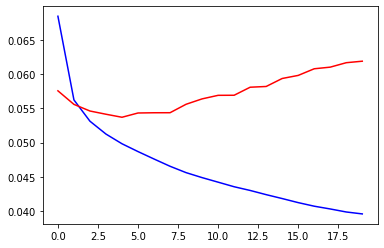

In [0]:
t = np.arange(len(avg_losses_f))
plt.figure()

plt.plot(t, avg_losses_f, 'b', t, avg_val_losses_f, 'r')
plt.show()

In [0]:
CPU = True
s = x_test.shape[0]
if CPU:
    # device = torch.device("cpu")
    model.cpu()
    x_tt = torch.tensor(x_train[:s], dtype=torch.long)
    y_tt = torch.tensor(y_train[:s], dtype=torch.float32)
    y_pp = model(x_tt)
    x_t = torch.tensor(x_test, dtype=torch.long)
    y_t = torch.tensor(y_test, dtype=torch.float32)
    y_p = model(x_t)
else:
    x_tt = torch.tensor(x_train, dtype=torch.long).cuda()
    y_tt = torch.tensor(y_train, dtype=torch.float32).cuda()
    y_pp = model(x_tt).detach()
    x_t = torch.tensor(x_test, dtype=torch.long).cuda()
    y_t = torch.tensor(y_test, dtype=torch.float32).cuda()
    y_p = model(x_t).detach()
    
print('Predicted Train accuracy ',(y_pp.argmax(dim=1)==y_tt.argmax(dim=1)).sum().cpu().numpy()/len(y_pp))
print('Predicted Test accuracy ',(y_p.argmax(dim=1)==y_t.argmax(dim=1)).sum().cpu().numpy()/len(y_p))

Predicted Train accuracy  0.7199223320305693
Predicted Test accuracy  0.5827338129496403


In [0]:
f1_score(y_t.argmax(dim=1).cpu(), y_p.argmax(dim=1).cpu(),list(int_category.values()),average='weighted')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0

In [0]:
print('Train statistics:')
print('accuracy %s' % accuracy_score(y_pp.argmax(dim=1).cpu(), y_tt.argmax(dim=1).cpu()))
print(classification_report(y_tt.argmax(dim=1).cpu(), y_pp.argmax(dim=1).cpu(),target_names=list(int_category.values())))
print('Test statistics:')
print('accuracy %s' % accuracy_score(y_p.argmax(dim=1).cpu(), y_t.argmax(dim=1).cpu()))
print(classification_report(y_t.argmax(dim=1).cpu(), y_p.argmax(dim=1).cpu(),target_names=list(int_category.values())))

Train statistics:
accuracy 0.7199223320305693
                precision    recall  f1-score   support

          ARTS       0.44      0.45      0.44       297
ARTS & CULTURE       0.56      0.34      0.42       276
  BLACK VOICES       0.72      0.58      0.64       950
      BUSINESS       0.72      0.62      0.66      1199
       COLLEGE       0.57      0.50      0.53       218
        COMEDY       0.68      0.58      0.62      1023
         CRIME       0.74      0.77      0.75       678
CULTURE & ARTS       0.73      0.38      0.50       216
       DIVORCE       0.82      0.76      0.79       699
     EDUCATION       0.60      0.41      0.49       182
 ENTERTAINMENT       0.79      0.83      0.81      3177
   ENVIRONMENT       0.73      0.44      0.55       269
         FIFTY       0.53      0.28      0.37       274
  FOOD & DRINK       0.70      0.86      0.77      1267
     GOOD NEWS       0.52      0.38      0.44       282
         GREEN       0.53      0.56      0.54       497
H

# 6. Save necessary files

In [0]:
modelspath=os.path.join(curDir,'ModelData','Pytorch_Model')
if not os.path.exists(modelspath):
    os.makedirs(modelspath)
torch.save(model.state_dict(), os.path.join(modelspath,'model_state_dict_v3_2.pth'))
# torch.save(model, os.path.join(modelspath,'model_v2.pth'))
print('Saved')

Saved


In [0]:
# file_name="./model/glove_files/glove.840B.300d.txt"
# with open(file_name,'r') as f:
#     word_vocab = set() # not using list to avoid duplicate entry
#     word2vector = {}
#     i=0
#     c=0
#     for line in f:
#         line_ = line.strip() #Remove white space
#         words_Vec = line_.split()
#         word_vocab.add(words_Vec[0])
#         try:
#             word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
#         except ValueError:
#             print(len(words_Vec), words_Vec[:len(words_Vec)-299])
#             if c == 5:
#                 print(i)
#                 print(words_Vec[1:])
#                 print(word2vector[words_Vec[0]])
#                 break
#             c += 1
#         i += 1
# print("Total Words in DataSet:",len(word_vocab))
# print(len(word2vector))
# print(i-len(word2vector))

In [0]:
# tsne = TSNE(n_components=2, random_state=0)
# # words =  list(embeddings_dict.keys())
# words = vocab
# # words = ["branch", "twig", "finger", "hand"]
# vectors = [w2v[word] for word in words]
# Y = tsne.fit_transform(vectors[:250])
# plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
# plt.scatter(Y[:, 0], Y[:, 1])

# for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
#     plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
# plt.show()